# Training Data

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Create tensorflow dataset

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "CatBreedData",
    batch_size = BATCH_SIZE
)

Found 7000 files belonging to 20 classes.


### Resize training images

In [6]:
class_names = dataset.class_names

In [7]:
def resize_images(image, label):
    resized_image = tf.image.resize(image, (256, 256))
    return resized_image, label

# Map the resize function to the dataset
dataset = dataset.map(resize_images)

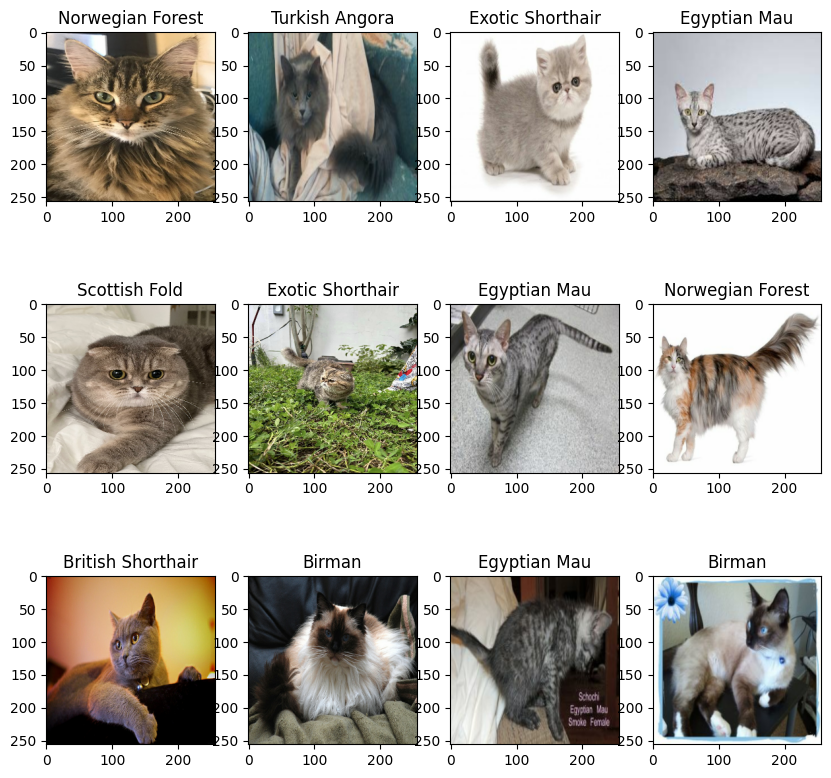

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [9]:
len(dataset)*0.8

175.20000000000002

### Partition dataset into training, validation, and testing

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Data augmentation

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Create Convolutional Neural Network Model

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Model Compilation

Using adam optimizer

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  0
TensorFlow version: 2.13.1


In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
)

Epoch 1/40


175/175 [==============================] - 213s 1s/step - loss: 2.9969 - accuracy: 0.0457 - val_loss: 2.9954 - val_accuracy: 0.0437
Epoch 2/40
175/175 [==============================] - 201s 1s/step - loss: 2.9579 - accuracy: 0.0716 - val_loss: 2.8583 - val_accuracy: 0.0949
Epoch 3/40
175/175 [==============================] - 201s 1s/step - loss: 2.8224 - accuracy: 0.1321 - val_loss: 2.7069 - val_accuracy: 0.1416
Epoch 4/40
175/175 [==============================] - 202s 1s/step - loss: 2.6845 - accuracy: 0.1704 - val_loss: 2.6120 - val_accuracy: 0.1852
Epoch 5/40
175/175 [==============================] - 205s 1s/step - loss: 2.5541 - accuracy: 0.2032 - val_loss: 2.5329 - val_accuracy: 0.1928
Epoch 6/40
175/175 [==============================] - 201s 1s/step - loss: 2.4210 - accuracy: 0.2373 - val_loss: 2.3993 - val_accuracy: 0.2395
Epoch 7/40
175/175 [==============================] - 200s 1s/step - loss: 2.3057 - accuracy: 0.2709 - val_loss: 2.2800 - val_accuracy: 0.2711
Epoch 8/40

In [23]:
scores = model.evaluate(test_ds)

23/23 [==============================] - 5s 206ms/step - loss: 1.5607 - accuracy: 0.8234


### Plotting Data

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (50,) and (40,)

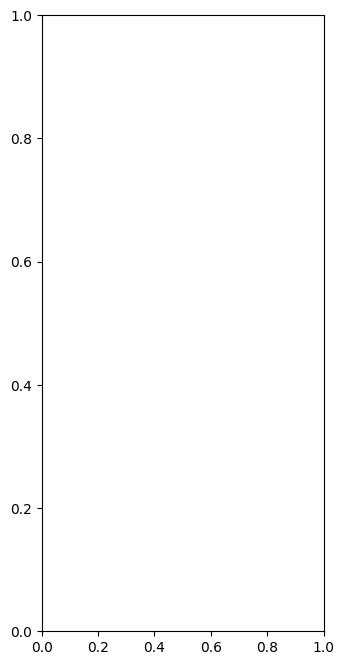

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Maine Coon
1/1 [==============================] - 0s 226ms/step
[2.0498663e-02 8.2190229e-05 1.1199221e-06 1.0495597e-02 1.0743151e-01
 7.8444000e-06 2.9994428e-08 4.2522070e-03 9.9515747e-03 1.8077282e-05
 8.1088495e-01 1.3144675e-04 2.3814386e-05 2.6232586e-04 1.3590642e-05
 1.2055917e-06 2.4977510e-06 2.2529703e-05 3.5849430e-02 6.9249276e-05]
predicted label: Maine Coon


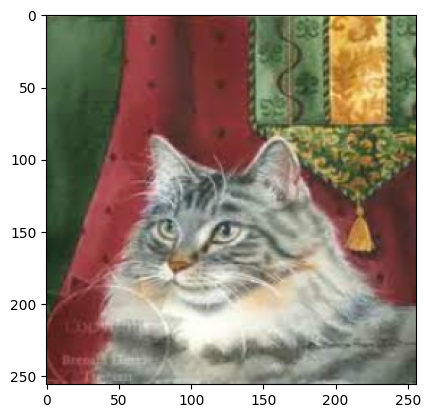

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 30ms/step


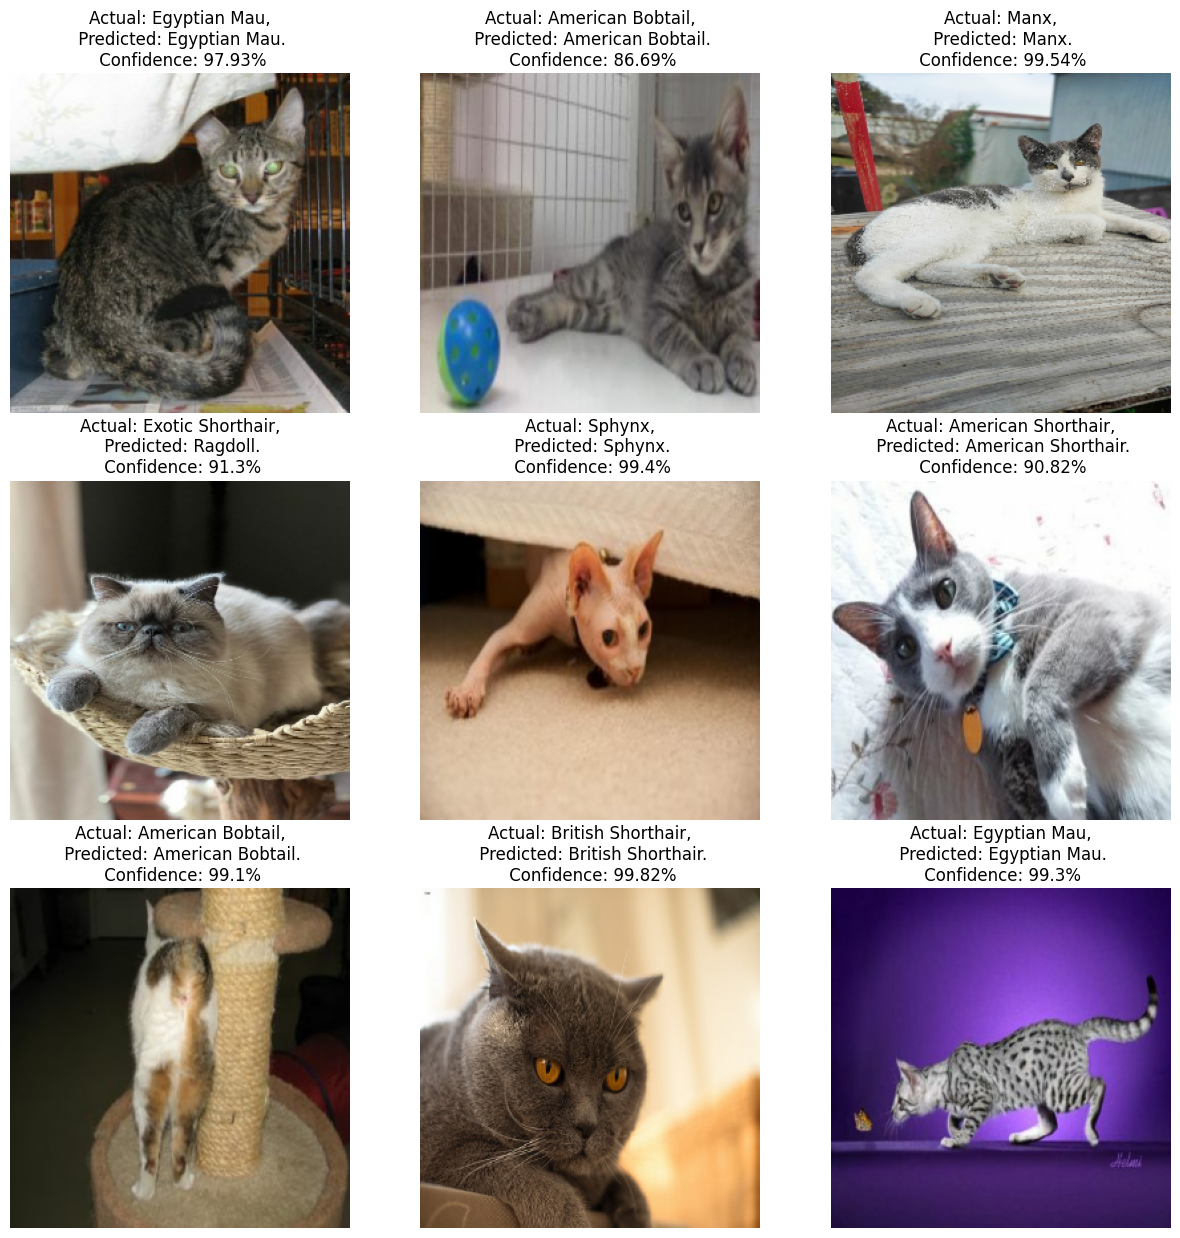

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [36]:
model.save("../cats.h5")

C:\Users\Oles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
my_list = [4.2312220e-02, 3.1525540e-01, 8.6432882e-03, 5.7903726e-02, 7.1580554e-03, 1.5214826e-04, 1.8854050e-01, 9.3365029e-02, 8.5842106e-03, 4.0058005e-03, 1.7474035e-02, 8.9599015e-03, 6.1395657e-03, 4.6511076e-02, 2.2487075e-03, 9.5908634e-02, 1.1547348e-02, 2.4916488e-04, 1.7835747e-02, 6.7205392e-02]

max_index = np.argmax(my_list)

print("Index of the maximum value:", max_index)

Index of the maximum value: 1
